In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



In [2]:
from data.dataset import CoDeTM4


/home/bosa/diplomska/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train, val, test  = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)


In [4]:
from datasets import concatenate_datasets


In [5]:
codet = concatenate_datasets([train, val, test])


In [6]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

# Enable comment parsing by setting `parser.set_included_ranges` with full range of the source code
# This is a workaround: tree-sitter parsers by default include comments as nodes, 
# so no extra flag is needed, but if previously you filtered comments, do not filter now.


In [7]:
import matplotlib.pyplot as plt


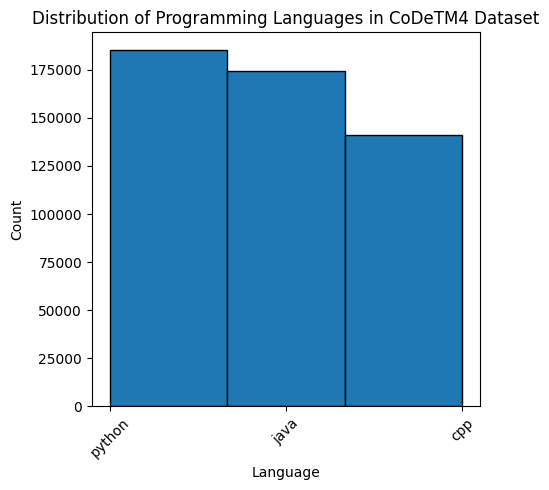

Python count: 185163
Java count: 174169
C++ count: 141220


In [8]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')


In [14]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")


In [13]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    # Include full range to keep comments included
    code_bytes = bytes(sample[code_key], 'utf-8')
    # Use full range
    #parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # Reset included ranges to None after parse to avoid side effects
    #parser.set_included_ranges(None)
    return tree


In [12]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()


In [11]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types


In [13]:
def extract_types(sample):
    # Import everything needed inside the function
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    parser = get_parser(sample['language'])
    code_bytes = sample['code'].encode('utf-8')
    # parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # parser.set_included_ranges(None)
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")


Collected 565 unique node types


In [14]:
all_types = sorted(list(all_types))


In [15]:
type_to_ind = {t: i for i, t in enumerate(all_types)}


In [16]:
len(all_types)

565

In [17]:
for t in all_types:
    print(t)



!
!=
"
""
#define
#elif
#else
#endif
#if
#ifdef
#ifndef
#include
%
%=
&
&&
&=
'
(
()
)
*
**
**=
*=
+
++
+=
,
-
--
-=
->
.
.*
...
/
//
//=
/=
:
::
:=
;
<
<<
<<=
<=
<=>
<>
=
==
>
>=
>>
>>=
>>>
>>>=
?
@
@interface
ERROR
L"
L'
NULL
R"
U"
[
[[
[]
\
]
]]
^
^=
_
__asm
__asm__
__attribute
__attribute__
__future__
__inline
__restrict__
__volatile__
abstract
abstract_array_declarator
abstract_function_declarator
abstract_parenthesized_declarator
abstract_pointer_declarator
abstract_reference_declarator
access_specifier
alias_declaration
aliased_import
alignas
alignas_qualifier
alignof
alignof_expression
and
annotated_type
annotation
annotation_argument_list
annotation_type_body
annotation_type_declaration
annotation_type_element_declaration
argument_list
array_access
array_creation_expression
array_declarator
array_initializer
array_type
as
as_pattern
as_pattern_target
asm
assert
assert_statement
assignment
assignment_expression
asterisk
async
attribute
attribute_declaration
attribute_specifie

In [10]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node


In [9]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id


In [20]:
from tqdm import tqdm


In [8]:
def create_graph(sample, code_key='cleaned_code'):
    tree = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target_binary']], dtype=tlong)

    graph_features = tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data



In [22]:
codet


Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 500552
})

In [7]:
def create_graphs(dataset, desc_keyword, code_key='cleaned_code'):
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample, code_key)
        graphs.append(data)

    return graphs
    


In [24]:
from torch_geometric.data import Data
from torch import save

train_graphs = create_graphs(train, 'train', 'code')
save(train_graphs, '../../data/codet_graphs/train_graphs_comments.pt')
del train, train_graphs
val_graphs = create_graphs(val, 'val', 'code')
save(val_graphs, '../../data/codet_graphs/val_graphs_comments.pt')
del val, val_graphs
test_graphs = create_graphs(test, 'test', 'code')
save(test_graphs, '../../data/codet_graphs/test_graphs_comments.pt')
del test, test_graphs
save(type_to_ind, '../../data/codet_graphs/type_to_ind_comments.pt')


Creating test graphs: 100%|██████████| 47749/47749 [00:41<00:00, 1157.62it/s]


In [1]:
from torch import load


In [2]:
from torch_geometric.data import Data


/home/bosa/diplomska/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_graphs = load('../../data/codet_graphs/train_graphs_comments.pt', weights_only=False)


In [4]:
type_to_ind = load('../../data/codet_graphs/type_to_ind_comments.pt', weights_only=False)


In [5]:
len(train_graphs)


405069

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, figsize=(15, 10), show_labels=True):
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=False)
    
    plt.figure(figsize=figsize)
    
    # Create tree layout manually
    pos = {}
    
    # Find root (node with no incoming edges)
    root = 0
    for node in G.nodes():
        if G.in_degree(node) == 0:
            root = node
            break
    
    # Assign positions level by level
    levels = {}
    queue = [(root, 0)]
    
    while queue:
        node, level = queue.pop(0)
        levels[node] = level
        
        # Add children to next level
        for child in G.successors(node):
            queue.append((child, level + 1))
    
    # Group nodes by level
    level_groups = {}
    for node, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(node)
    
    # Position nodes
    for level, nodes in level_groups.items():
        for i, node in enumerate(nodes):
            x = i - len(nodes) / 2  # Center nodes horizontally
            y = -level  # Higher levels at top
            pos[node] = (x, y)
    
    # Create labels if requested
    labels = None
    if show_labels:
        # Create reverse mapping from index to type
        ind_to_type = {v: k for k, v in type_to_ind.items()}
        labels = {}
        for node in G.nodes():
            node_type_idx = data.x[node].item()
            node_type = ind_to_type.get(node_type_idx, f"idx_{node_type_idx}")
            labels[node] = node_type
    
    nx.draw(G, pos, with_labels=show_labels, labels=labels, 
            node_color='lightblue', node_size=500, arrows=True, 
            font_size=6 if show_labels else 8)
    
    plt.title("AST Tree")
    plt.show()



In [17]:
train_graphs[1]

Data(
  x=[48],
  edge_index=[2, 47],
  y=[1],
  graph_features=[8],
  metadata={
    language='python',
    target='human',
    target_binary=0,
    code='def reload(self):
        """Reload catalog if sufficient time has passed"""
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
    cleaned_code='def reload(self):
        
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
  }
)

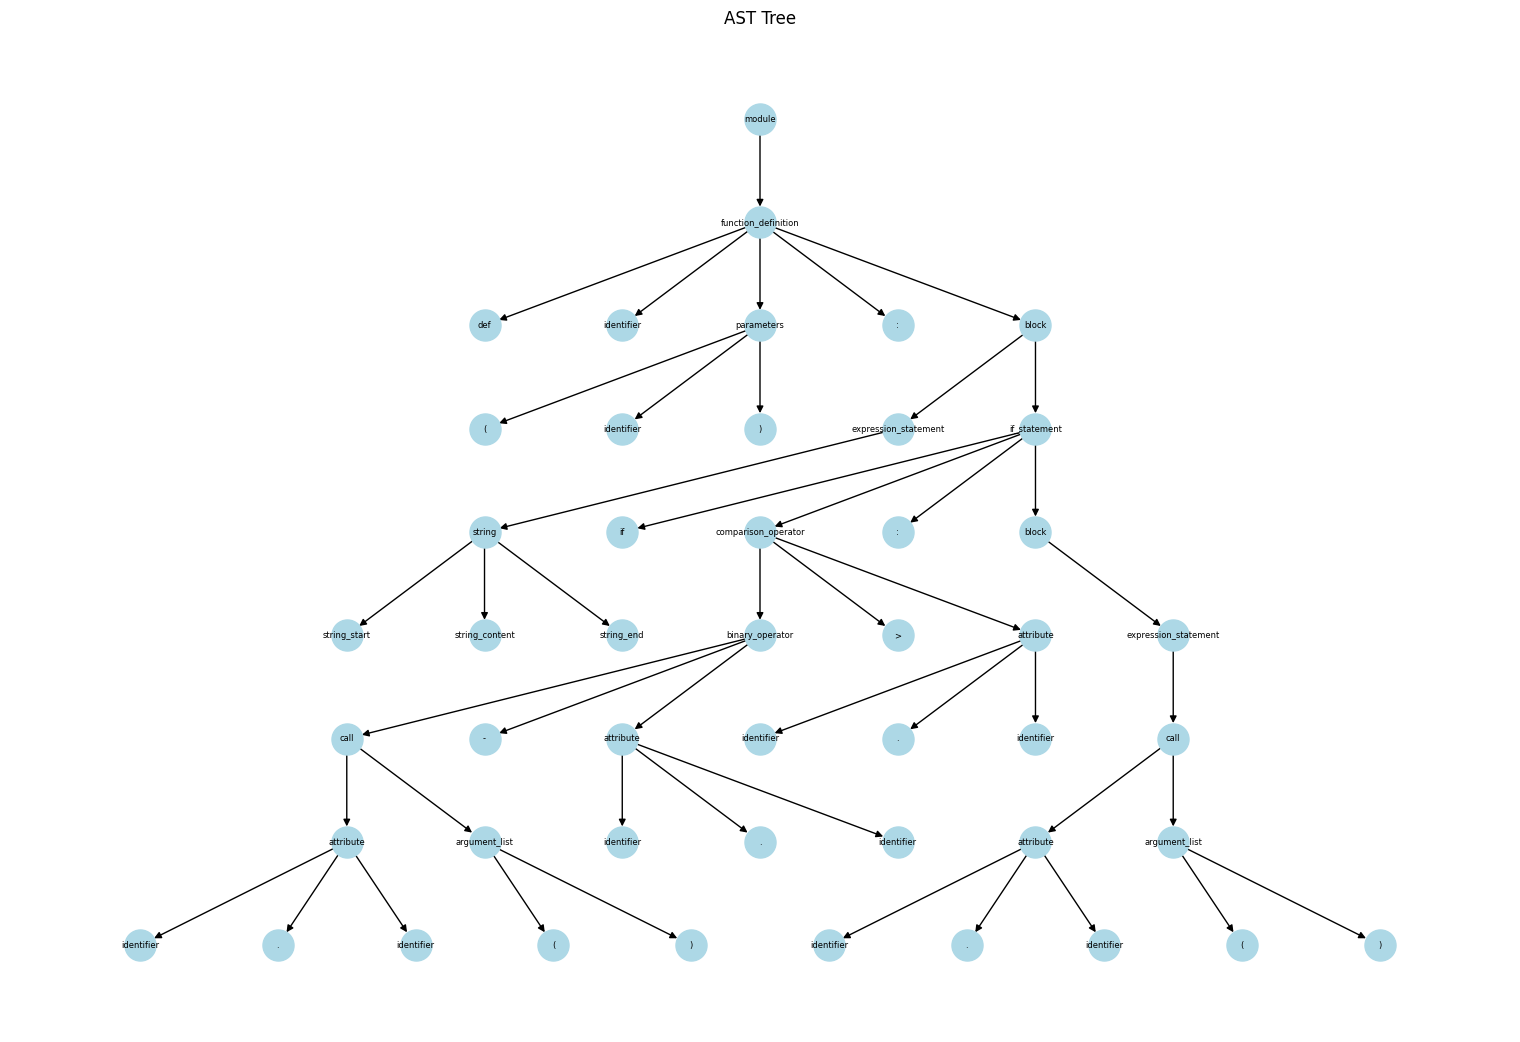

In [19]:
visualize_graph(train_graphs[1], show_labels=True)


In [ ]:
# Load test graphs and inspect comment nodes
from torch import load
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language, TreeCursor

# Load the test graphs
test_graphs = load('../../data/codet_graphs/test_graphs_comments.pt', weights_only=False)
type_to_ind = load('../../data/codet_graphs/type_to_ind_comments.pt', weights_only=False)

# Setup parsers
TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER = Parser(language=TS_PYTHON)
JAVA_PARSER = Parser(language=TS_JAVA)
CPP_PARSER = Parser(language=TS_CPP)

def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")

def inspect_comment_nodes(graph_data, show_code=True):
    """Inspect comment nodes in a graph by re-parsing the original code"""
    metadata = graph_data.metadata
    language = metadata['language']
    code = metadata['code']
    
    if show_code:
        print(f"Original code ({language}):")
        print("=" * 50)
        print(code)
        print("=" * 50)
    
    # Parse the code to find comment nodes
    parser = get_parser(language)
    tree = parser.parse(code.encode('utf-8'))
    cursor = tree.walk()
    
    def find_comments(cursor, depth=0):
        node_type = cursor.node.type
        if 'comment' in node_type.lower():
            comment_text = cursor.node.text.decode('utf-8')
            start_point = cursor.node.start_point
            end_point = cursor.node.end_point
            print(f"Found {node_type}:")
            print(f"  Text: {repr(comment_text)}")
            print(f"  Position: line {start_point.row+1}, col {start_point.column} to line {end_point.row+1}, col {end_point.column}")
            print()
        
        if cursor.goto_first_child():
            find_comments(cursor, depth+1)
            while cursor.goto_next_sibling():
                find_comments(cursor, depth+1)
            cursor.goto_parent()
    
    print(f"Comment nodes found in {language} code:")
    print("-" * 30)
    find_comments(cursor)

# Inspect comment nodes in the first test graph
print(f"Loaded {len(test_graphs)} test graphs")
print(f"Inspecting graph 0...")
inspect_comment_nodes(test_graphs[0])

In [1]:
from torch import load
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language, TreeCursor

# Load the test graphs
test_graphs = load('../../data/codet_graphs/test_graphs_comments.pt', weights_only=False)
type_to_ind = load('../../data/codet_graphs/type_to_ind_comments.pt', weights_only=False)

# Setup parsers
TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER = Parser(language=TS_PYTHON)
JAVA_PARSER = Parser(language=TS_JAVA)
CPP_PARSER = Parser(language=TS_CPP)

/home/bosa/diplomska/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Display type_to_ind mapping in a readable format
print(f"Total number of node types: {len(type_to_ind)}")
print("\nNode type mappings (type -> index):")
print("=" * 50)

# Sort by index for better readability
sorted_types = sorted(type_to_ind.items(), key=lambda x: x[1])

# Define more precise control-flow patterns - looking for actual statement/expression types
control_flow_patterns = [
    # Conditional statements
    'if_statement', 'if_expression', 'conditional_expression', 'ternary_expression',
    'else_clause', 'elif_clause', 'else_statement',
    
    # Loop statements
    'for_statement', 'while_statement', 'do_statement', 'for_in_statement',
    'enhanced_for_statement', 'for_each_statement',
    
    # Jump statements  
    'break_statement', 'continue_statement', 'return_statement', 'goto_statement',
    
    # Exception handling
    'try_statement', 'catch_clause', 'finally_clause', 'throw_statement',
    'except_clause', 'raise_statement', 'with_statement',
    
    # Switch/case statements
    'switch_statement', 'switch_expression', 'case_clause', 'default_clause',
    
    # Assert statements
    'assert_statement', 'assertion',
    
    # Yield statements
    'yield_statement', 'yield_expression'
]

def is_control_flow_node(node_type):
    """More precise detection of control-flow nodes"""
    node_lower = node_type.lower()
    
    # Exact matches for known control-flow patterns
    if node_lower in [pattern.lower() for pattern in control_flow_patterns]:
        return True
    
    # Additional pattern matching for variations
    # Look for statement/expression endings with control flow keywords
    control_keywords = ['if', 'else', 'for', 'while', 'switch', 'case', 'try', 'catch', 'finally']
    
    for keyword in control_keywords:
        # Match patterns like "if_stmt", "else_clause", "for_loop", etc.
        if (node_lower == keyword or 
            node_lower.startswith(keyword + '_') or 
            node_lower.endswith('_' + keyword) or
            (keyword + '_statement' in node_lower) or
            (keyword + '_expression' in node_lower) or
            (keyword + '_clause' in node_lower)):
            return True
    
    # Special cases for compound statements
    if any(pattern in node_lower for pattern in ['_statement', '_clause', '_expression'] if 
           any(kw in node_lower for kw in ['break', 'continue', 'return', 'goto', 'yield', 'raise', 'assert', 'throw'])):
        return True
    
    return False

# Categorize node types
control_flow_types = []
comment_types = []
other_types = []

for node_type, index in sorted_types:
    if 'comment' in node_type.lower():
        comment_types.append((node_type, index))
    elif is_control_flow_node(node_type):
        control_flow_types.append((node_type, index))
    else:
        other_types.append((node_type, index))

# Display with highlighting
for i, (node_type, index) in enumerate(sorted_types):
    if is_control_flow_node(node_type):
        print(f"{index:3d}: {node_type} ⭐ CONTROL-FLOW")
    elif 'comment' in node_type.lower():
        print(f"{index:3d}: {node_type} 💬 COMMENT")
    else:
        print(f"{index:3d}: {node_type}")
    
print("=" * 50)

# Show statistics
print(f"\nControl-flow related node types found: {len(control_flow_types)}")
for node_type, index in control_flow_types:
    print(f"  ⭐ {node_type} (index: {index})")

print(f"\nComment-related node types found: {len(comment_types)}")
for node_type, index in comment_types:
    print(f"  💬 {node_type} (index: {index})")

print(f"\nOther node types: {len(other_types)}")
print(f"Total types: {len(control_flow_types)} control-flow + {len(comment_types)} comments + {len(other_types)} others = {len(type_to_ind)}")

# Debug: Show potentially missed patterns
print(f"\nPotential control-flow nodes that might be missed:")
potential_cf = [node_type for node_type, _ in other_types if 
                any(kw in node_type.lower() for kw in ['if', 'else', 'for', 'while', 'loop', 'break', 'continue', 'return', 'switch', 'case'])]
if potential_cf:
    for node_type in potential_cf[:10]:  # Show first 10
        print(f"  ? {node_type}")
    if len(potential_cf) > 10:
        print(f"  ... and {len(potential_cf) - 10} more")
else:
    print("  None found - good!")

Total number of node types: 565

Node type mappings (type -> index):
  0: 

  1: !
  2: !=
  3: "
  4: ""
  5: #define
  6: #elif
  7: #else
  8: #endif
  9: #if
 10: #ifdef
 11: #ifndef
 12: #include
 13: %
 14: %=
 15: &
 16: &&
 17: &=
 18: '
 19: (
 20: ()
 21: )
 22: *
 23: **
 24: **=
 25: *=
 26: +
 27: ++
 28: +=
 29: ,
 30: -
 31: --
 32: -=
 33: ->
 34: .
 35: .*
 36: ...
 37: /
 38: //
 39: //=
 40: /=
 41: :
 42: ::
 43: :=
 44: ;
 45: <
 46: <<
 47: <<=
 48: <=
 49: <=>
 50: <>
 51: =
 52: ==
 53: >
 54: >=
 55: >>
 56: >>=
 57: >>>
 58: >>>=
 59: ?
 60: @
 61: @interface
 62: ERROR
 63: L"
 64: L'
 65: NULL
 66: R"
 67: U"
 68: [
 69: [[
 70: []
 71: \
 72: ]
 73: ]]
 74: ^
 75: ^=
 76: _
 77: __asm
 78: __asm__
 79: __attribute
 80: __attribute__
 81: __future__
 82: __inline
 83: __restrict__
 84: __volatile__
 85: abstract
 86: abstract_array_declarator
 87: abstract_function_declarator
 88: abstract_parenthesized_declarator
 89: abstract_pointer_declarator
 90: abstra

In [20]:
# Create shorter switch/case examples for all three languages
switch_case_examples = {
    'java': '''
switch (x) {
    case 1:
        return "one";
    case 2:
        return "two";
    default:
        return "other";
}
''',
    'cpp': '''
switch (grade) {
    case 'A':
        cout << "Excellent";
        break;
    case 'B':
        cout << "Good";
        break;
    default:
        cout << "Try again";
}
''',
    'python': '''
match status:
    case "on":
        return True
    case "off":
        return False
    case _:
        return None
'''
}

print("Shorter Switch/Case examples created for all three languages:")
for lang, code in switch_case_examples.items():
    print(f"\n{lang.upper()}:")
    print("=" * 40)
    print(code.strip())

Shorter Switch/Case examples created for all three languages:

JAVA:
switch (x) {
    case 1:
        return "one";
    case 2:
        return "two";
    default:
        return "other";
}

CPP:
switch (grade) {
    case 'A':
        cout << "Excellent";
        break;
    case 'B':
        cout << "Good";
        break;
    default:
        cout << "Try again";
}

PYTHON:
match status:
    case "on":
        return True
    case "off":
        return False
    case _:
        return None


In [21]:
# Create sample data structures for our switch/case examples
switch_case_samples = []

for language, code in switch_case_examples.items():
    sample = {
        'language': language,
        'code': code.strip(),
        'cleaned_code': code.strip(),
        'target_binary': 1,  # dummy target
        'target': 'positive',  # dummy target
        'features': {  # dummy features
            'num_lines': len(code.strip().split('\n')),
            'num_chars': len(code.strip()),
            'complexity': 3.0
        }
    }
    switch_case_samples.append(sample)

print(f"Created {len(switch_case_samples)} switch/case samples")

# Generate graphs for our examples
switch_case_graphs = []
for i, sample in enumerate(switch_case_samples):
    print(f"\nProcessing {sample['language']} example...")
    try:
        graph = create_graph(sample, code_key='code')
        switch_case_graphs.append(graph)
        print(f"✓ Successfully created graph with {graph.x.size(0)} nodes and {graph.edge_index.size(1)} edges")
    except Exception as e:
        print(f"✗ Error creating graph: {e}")

print(f"\nSuccessfully created {len(switch_case_graphs)} graphs from switch/case examples")

Created 3 switch/case samples

Processing java example...
✓ Successfully created graph with 45 nodes and 44 edges

Processing cpp example...
✓ Successfully created graph with 60 nodes and 59 edges

Processing python example...
✓ Successfully created graph with 39 nodes and 38 edges

Successfully created 3 graphs from switch/case examples



ANALYSIS FOR JAVA SWITCH/CASE EXAMPLE
Graph stats:
  - Total nodes: 45
  - Unique node types: 22
  - Total edges: 44

Control-flow nodes found (14):
  ⭐ Node 1: switch_expression
  ⭐ Node 2: switch
  ⭐ Node 7: switch_block
  ⭐ Node 9: switch_block_statement_group
  ⭐ Node 10: switch_label
  ⭐ Node 11: case
  ⭐ Node 14: return_statement
  ⭐ Node 21: switch_block_statement_group
  ⭐ Node 22: switch_label
  ⭐ Node 23: case
  ⭐ Node 26: return_statement
  ⭐ Node 33: switch_block_statement_group
  ⭐ Node 34: switch_label
  ⭐ Node 37: return_statement

All unique node types in java graph:
    "
    (
    )
    :
    ;
  ⭐ case
    decimal_integer_literal
    default
    identifier
    parenthesized_expression
    program
    return
  ⭐ return_statement
    string_fragment
    string_literal
  ⭐ switch
  ⭐ switch_block
  ⭐ switch_block_statement_group
  ⭐ switch_expression
  ⭐ switch_label
    {
    }

Visualizing java switch/case graph...


<Figure size 1200x800 with 0 Axes>

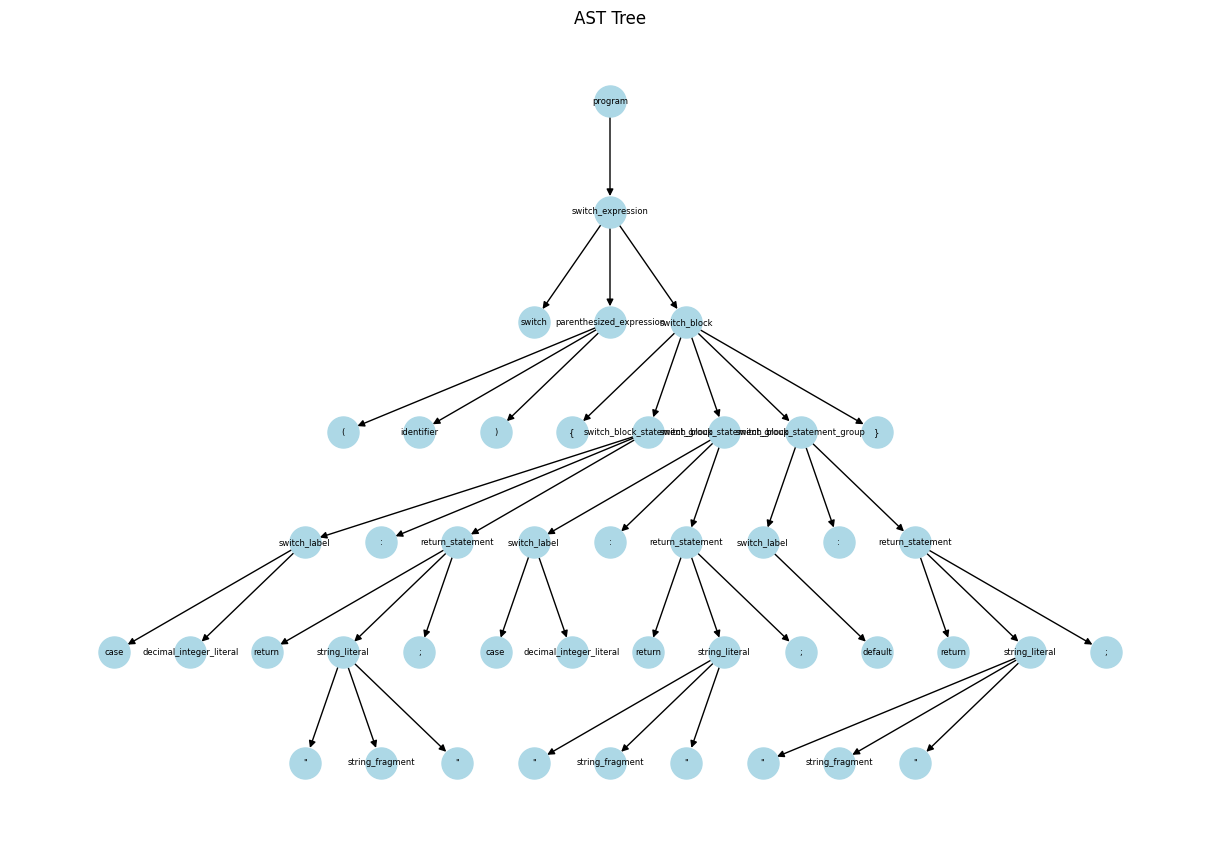


ANALYSIS FOR CPP SWITCH/CASE EXAMPLE
Graph stats:
  - Total nodes: 60
  - Unique node types: 26
  - Total edges: 59

Control-flow nodes found (9):
  ⭐ Node 1: switch_statement
  ⭐ Node 2: switch
  ⭐ Node 9: case_statement
  ⭐ Node 10: case
  ⭐ Node 25: break_statement
  ⭐ Node 28: case_statement
  ⭐ Node 29: case
  ⭐ Node 44: break_statement
  ⭐ Node 47: case_statement

All unique node types in cpp graph:
    "
    '
    (
    )
    :
    ;
    <<
    binary_expression
    break
  ⭐ break_statement
  ⭐ case
  ⭐ case_statement
    char_literal
    character
    compound_statement
    condition_clause
    default
    expression_statement
    identifier
    string_content
    string_literal
  ⭐ switch
  ⭐ switch_statement
    translation_unit
    {
    }

Visualizing cpp switch/case graph...


<Figure size 1200x800 with 0 Axes>

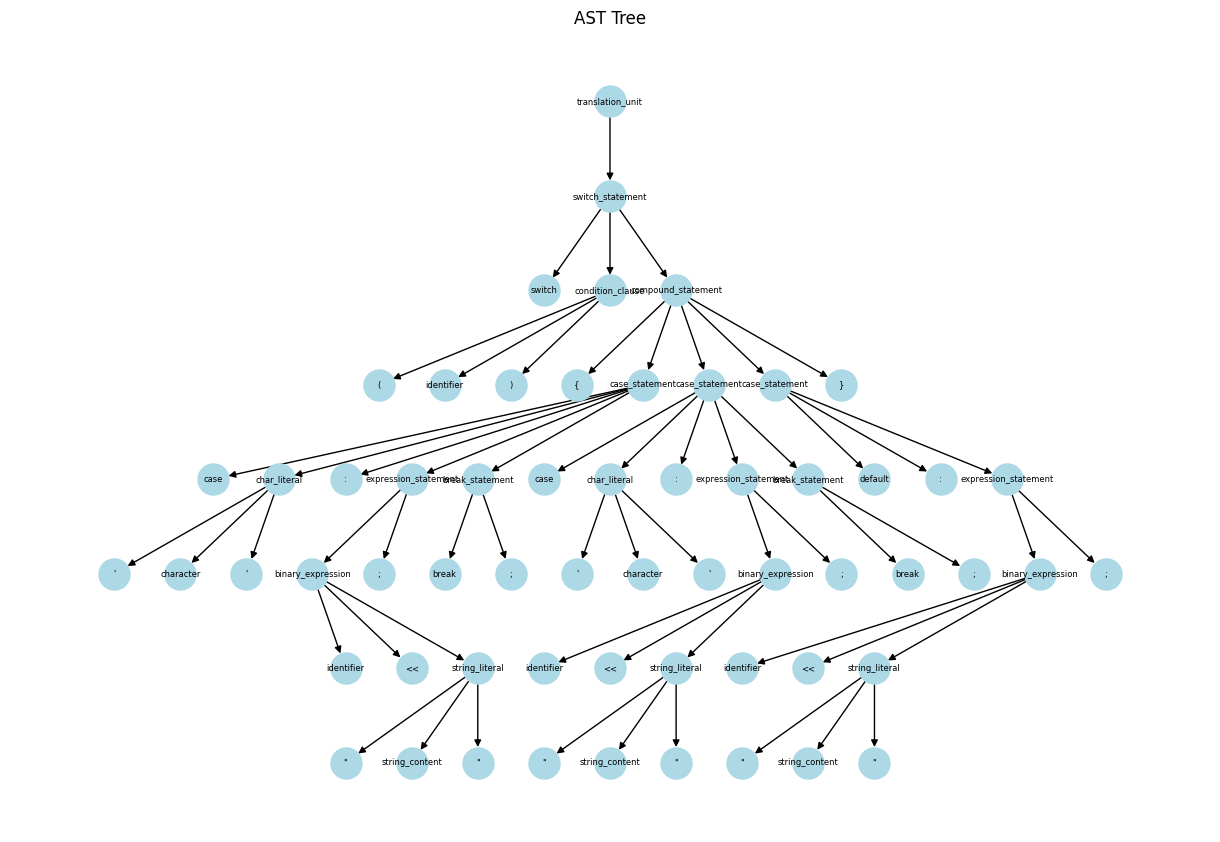


ANALYSIS FOR PYTHON SWITCH/CASE EXAMPLE
Graph stats:
  - Total nodes: 39
  - Unique node types: 19
  - Total edges: 38

Control-flow nodes found (12):
  ⭐ Node 6: case_clause
  ⭐ Node 7: case
  ⭐ Node 8: case_pattern
  ⭐ Node 15: return_statement
  ⭐ Node 18: case_clause
  ⭐ Node 19: case
  ⭐ Node 20: case_pattern
  ⭐ Node 27: return_statement
  ⭐ Node 30: case_clause
  ⭐ Node 31: case
  ⭐ Node 32: case_pattern
  ⭐ Node 36: return_statement

All unique node types in python graph:
    :
    _
    block
  ⭐ case
  ⭐ case_clause
  ⭐ case_pattern
    false
    identifier
    match
    match_statement
    module
    none
    return
  ⭐ return_statement
    string
    string_content
    string_end
    string_start
    true

Visualizing python switch/case graph...


<Figure size 1200x800 with 0 Axes>

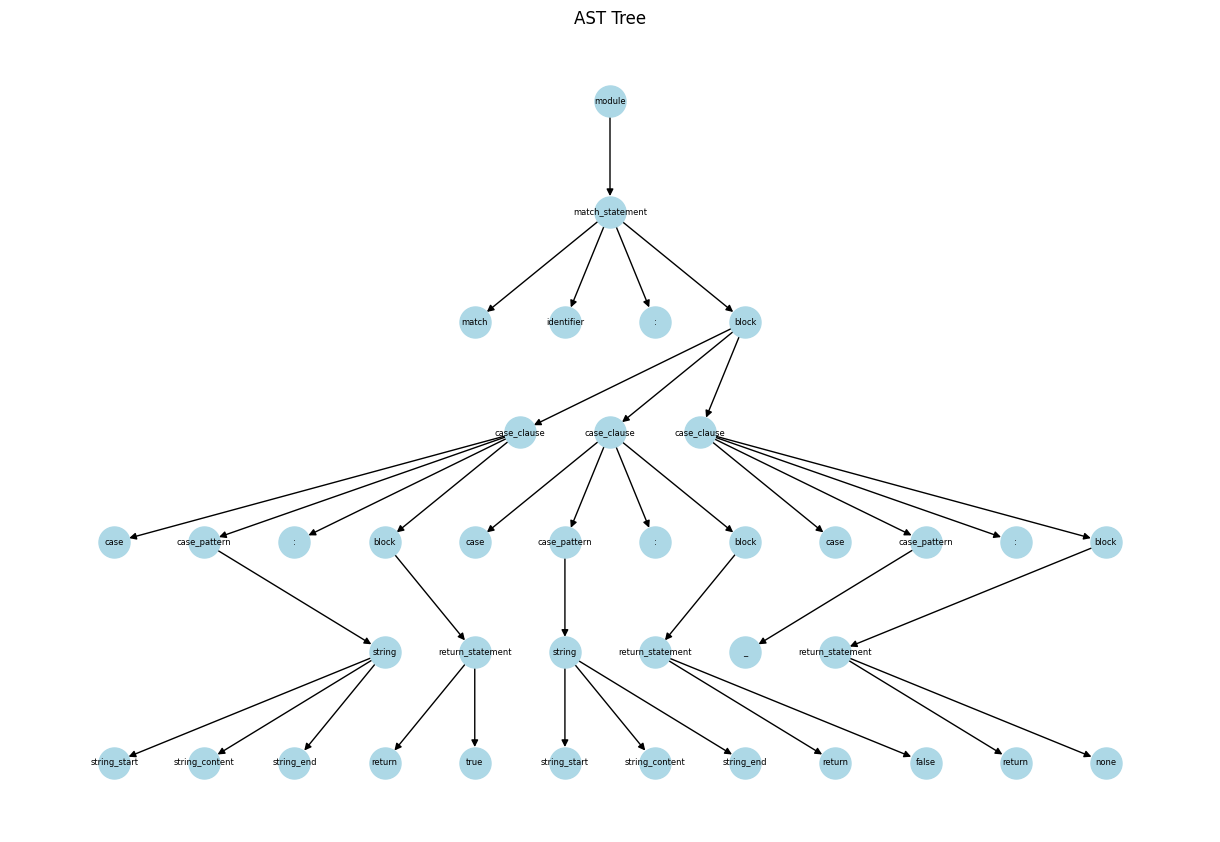


SUMMARY OF CONTROL-FLOW PATTERNS ACROSS LANGUAGES
JAVA: 14 control-flow nodes, types: {'switch_label', 'return_statement', 'case', 'switch_expression', 'switch_block_statement_group', 'switch', 'switch_block'}
CPP: 9 control-flow nodes, types: {'break_statement', 'case', 'switch_statement', 'case_statement', 'switch'}
PYTHON: 12 control-flow nodes, types: {'case_clause', 'case_pattern', 'case', 'return_statement'}

All control-flow types found across examples: ['break_statement', 'case', 'case_clause', 'case_pattern', 'case_statement', 'return_statement', 'switch', 'switch_block', 'switch_block_statement_group', 'switch_expression', 'switch_label', 'switch_statement']


In [22]:
# Visualize the switch/case graphs and analyze control-flow nodes
import matplotlib.pyplot as plt

# Create reverse mapping for node type analysis
ind_to_type = {v: k for k, v in type_to_ind.items()}

for i, (graph, sample) in enumerate(zip(switch_case_graphs, switch_case_samples)):
    language = sample['language']
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR {language.upper()} SWITCH/CASE EXAMPLE")
    print(f"{'='*60}")
    
    # Analyze node types in this graph
    node_types = [ind_to_type[idx.item()] for idx in graph.x]
    unique_types = list(set(node_types))
    
    print(f"Graph stats:")
    print(f"  - Total nodes: {len(node_types)}")
    print(f"  - Unique node types: {len(unique_types)}")
    print(f"  - Total edges: {graph.edge_index.size(1)}")
    
    # Find control-flow related nodes
    control_flow_nodes = []
    comment_nodes = []
    
    for j, node_type in enumerate(node_types):
        if is_control_flow_node(node_type):
            control_flow_nodes.append((j, node_type))
        elif 'comment' in node_type.lower():
            comment_nodes.append((j, node_type))
    
    print(f"\nControl-flow nodes found ({len(control_flow_nodes)}):")
    for node_id, node_type in control_flow_nodes:
        print(f"  ⭐ Node {node_id}: {node_type}")
    
    if comment_nodes:
        print(f"\nComment nodes found ({len(comment_nodes)}):")
        for node_id, node_type in comment_nodes:
            print(f"  💬 Node {node_id}: {node_type}")
    
    print(f"\nAll unique node types in {language} graph:")
    for node_type in sorted(unique_types):
        if is_control_flow_node(node_type):
            print(f"  ⭐ {node_type}")
        elif 'comment' in node_type.lower():
            print(f"  💬 {node_type}")
        else:
            print(f"    {node_type}")
    
    # Visualize the graph
    print(f"\nVisualizing {language} switch/case graph...")
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"{language.upper()} Switch/Case AST Graph", fontsize=14, fontweight='bold')
    
    # Show the code in a text box
    plt.figtext(0.02, 0.02, f"Code:\n{sample['code'][:200]}...", 
                fontsize=8, family='monospace', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    visualize_graph(graph, figsize=(12, 8), show_labels=True)
    
print(f"\n{'='*60}")
print("SUMMARY OF CONTROL-FLOW PATTERNS ACROSS LANGUAGES")
print(f"{'='*60}")

# Summary analysis
all_cf_types = set()
for graph, sample in zip(switch_case_graphs, switch_case_samples):
    node_types = [ind_to_type[idx.item()] for idx in graph.x]
    cf_types = [nt for nt in node_types if is_control_flow_node(nt)]
    all_cf_types.update(cf_types)
    print(f"{sample['language'].upper()}: {len(cf_types)} control-flow nodes, types: {set(cf_types)}")

print(f"\nAll control-flow types found across examples: {sorted(all_cf_types)}")

In [24]:
test_graphs[1]['metadata']

{'language': 'python',
 'target': 'human',
 'target_binary': 0,
 'code': "def home_position_send(self, latitude, longitude, altitude, x, y, z, q, approach_x, approach_y, approach_z, force_mavlink1=False):\n                '''\n                This message can be requested by sending the MAV_CMD_GET_HOME_POSITION\n                command. The position the system will return to and\n                land on. The position is set automatically by the\n                system during the takeoff in case it was not\n                explicitely set by the operator before or after. The\n                position the system will return to and land on. The\n                global and local positions encode the position in the\n                respective coordinate frames, while the q parameter\n                encodes the orientation of the surface. Under normal\n                conditions it describes the heading and terrain slope,\n                which can be used by the aircraft to adjust the\n 